In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import scale

import researchpy as rp
from scipy import stats

In [2]:
bike_sharing_data = pd.read_csv('Data/day.csv')
bike_sharing_data.shape

(731, 16)

In [3]:
bike_sharing_data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
bike_sharing_data = bike_sharing_data[['season', 
                                       'mnth', 
                                       'holiday', 
                                       'workingday', 
                                       'weathersit', 
                                       'temp', 
                                       'cnt']]

In [5]:
bike_sharing_data.to_csv('Data/bike_sharing_data_processed.csv', index=False)

In [6]:
bike_sharing_data.head()

,season,mnth,holiday,workingday,weathersit,temp,cnt
0,1,1,0,0,2,0.344167,985
1,1,1,0,0,2,0.363478,801
2,1,1,0,1,1,0.196364,1349
3,1,1,0,1,1,0.200000,1562
4,1,1,0,1,1,0.226957,1600


In [7]:
bike_sharing_data['season'].unique()

array([1, 2, 3, 4], dtype=int64)

In [8]:
bike_sharing_data['workingday'].unique()

array([0, 1], dtype=int64)

In [9]:
bike_sharing_data['holiday'].unique()

array([0, 1], dtype=int64)

In [10]:
bike_sharing_data['weathersit'].unique()

array([2, 1, 3], dtype=int64)

In [11]:
bike_sharing_data['temp'].describe()

count    731.000000
mean       0.495385
std        0.183051
min        0.059130
25%        0.337083
50%        0.498333
75%        0.655417
max        0.861667
Name: temp, dtype: float64

In [12]:
bike_sharing_data.shape

(731, 7)

In [13]:
bike_sharing_data.groupby('workingday')['cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,231.0,4330.168831,2052.141245,605.0,2710.50,4459.0,5907.5,8714.0
1,500.0,4584.820000,1878.415583,22.0,3344.25,4582.0,5987.5,8362.0


We have 231 records for a non working day and 500 records for the working day, and the averages are also different. The average number of bikes rented on a non-working day is around 4330 for the working day is closer to 4600. But is this difference in the means significant? Let's use the t-test to find out.

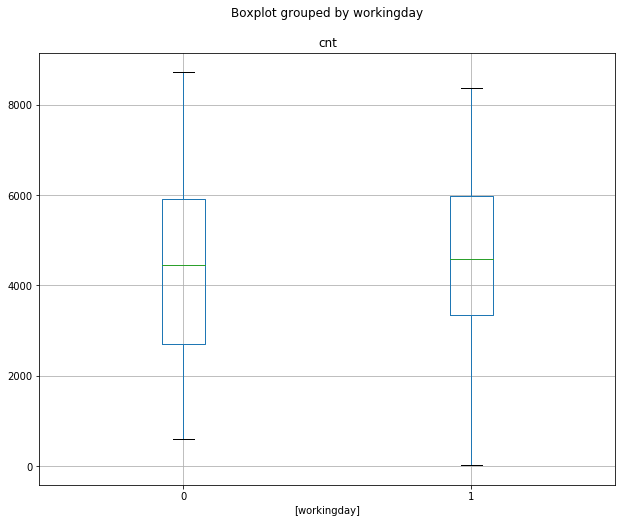

In [14]:
bike_sharing_data.boxplot(column=['cnt'], by=['workingday'], figsize=(10, 8))

The center line of the boxes gives us the median of the data, and the box itself is the inter quartile range. The medians are more or less the same.

In [15]:
sample_01 = bike_sharing_data[(bike_sharing_data['workingday'] == 1)]
sample_02 = bike_sharing_data[(bike_sharing_data['workingday'] == 0)]

In [16]:
sample_01.shape, sample_02.shape

((500, 7), (231, 7))

We have more records available for the working days as opposed to the non-working days. And for a t-test, we need both of the sample size is to be the same. We can fix this by sampling 231 records at random from sample one.

In [17]:
sample_01 = sample_01.sample(231)
sample_01.shape, sample_02.shape

((231, 7), (231, 7))

Both of our samples now have the same number of records equal to 231.

###  Performing the independent t-test

Before performing the t-test let's check the data to see whether the assumptions for the T test are satisfied. 
The first assumption - the variance off the two groups are the same. Now let's check whether this assumption holds true in our bike sharing data set. We can perform Levene's test on our two samples. This test will check whether the variance off the two groups are the same. This is exactly like the t-test, but for the variance of the two groups rather than the means of the two groups.

The null hypothesis off this Levene's test is that the variances off the two samples are exactly the same. The alternate hypothesis is that they're different. Levene's test will give us a test statistic on the p-value, exactly like the t-test.

In [40]:
stats.levene(sample_01['cnt'], sample_02['cnt'])

LeveneResult(statistic=1.1393762815681208, pvalue=0.28634402814552973)

The test statistic here is 2.5 and the p-value is 0.11. 

When the p-value is greater than 5% we can reject the alternate hypothesis and accept the null hypothesis. When the p-value is 11% as it is, we except the null hypothesis that the variances of the two samples are not significantly different. Our first assumption holds true for the independent t-test.

The next assumption for the data used in an independent t-test is that the distribution of the residuals between the two groups of the two samples should follow the normal distribution. 

There are a number of ways that we can evaluate this. The first step is to calculate the residuals between the two groups, which can be done by calculating the differences between the samples. Once we have the differences between the sample areas between our two groups of data, we need to scale this difference.

(array([  5.,  11.,  26.,  21.,  33.,  42.,  37.,  30.,  20.,   6.]),
 array([-2.46626743, -2.00223984, -1.53821225, -1.07418466, -0.61015707,
        -0.14612948,  0.31789811,  0.7819257 ,  1.24595329,  1.70998088,
         2.17400847]),
 <a list of 10 Patch objects>)

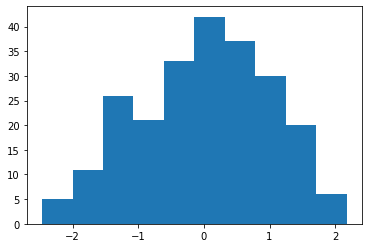

In [19]:
diff = scale(np.array(sample_01['cnt']) - np.array(sample_02['cnt'], dtype=float))
plt.hist(diff)

The scale function standardize our results. Standardization subtract the mean from every value that we have and divides by the standard deviation so that the resulting samples will have zero mean an unit variants of the unit standard deviation. 

The residue between the two samples will now be expressed in terms of z-score or number of standard deviations away from the mean, which make it easy to work with. Once we have the standardized residents between the two groups, I'm going to plot histogramm to see if these residuals are normally distributed.

From this histogram we can see that the data does seem to follow a normal distribution, but this is a very rough check. There are other statistical techniques that we can use to do a more formal check for normal distribution. We'll use something called a QQ plot or a probability plot.

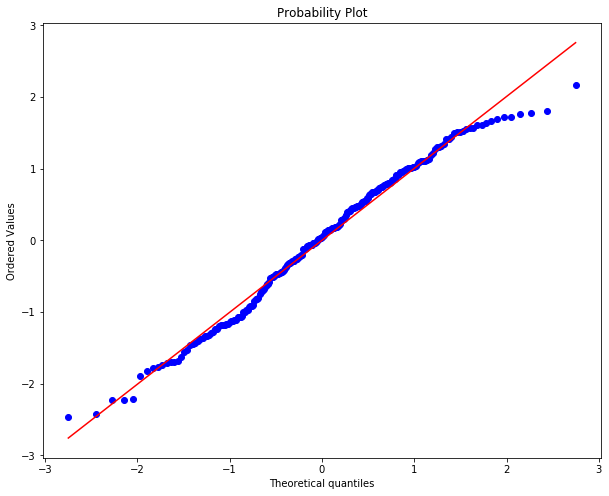

In [20]:
plt.figure(figsize=(10, 8))
stats.probplot(diff, plot=plt, dist='norm')
plt.show()

The data that we want to evaluate is the residue is between our two groups. The groups are the number of bike share on a working day versus a non-working day. The political distribution against which we perform our comparison is the normal distribution. This QQ plot will check how the distribution of the residuals compares against normally distributed data. 

Our residual data very closely follows the normal distribution. It's not a perfect match at greater than two standard deviations away from the mean on either side. The data does not track the red line, which is the quartile information for normally distributed data. The rest of the data is very close to being normally distributed so we can accept this. The second assumption for the independent detest has been satisfied. 

Another way to check whether the residuas are normally distributed is to use the Shapiro-Wilk test for normality. This test will once again give us a t-statistic and a p-value.

In [39]:
stats.shapiro(diff)

(0.9923050403594971, 0.05721497908234596)

Another way to check whether the residuals are normally distributed is to use the Shapiro-Wilk test for normality. This test will once again give us a test-statistic and a p-value. If the test statistic is not significant than the population can be considered to be normally distributed. The null hypothesis assumes normally distributed data. 

We can see that the p-value here is 0.41 That is 41%. This means the Shapiro-Wilk test is not significant. Our residual data is normally distributed. 

With all our test assumptions satisfied on the data we can now perform The independent t-test. The count of bike shered on working days versus non working days.

In [41]:
stats.ttest_ind(sample_01['cnt'], sample_02['cnt'])

Ttest_indResult(statistic=1.5351812143000521, pvalue=0.12542681274203951)

The p-value is 0.02 (that is < 0.05) which means we can reject the null hypothesis and accept the alternative hypothesis.

In [42]:
descriptives, results = rp.ttest(sample_01['cnt'], sample_02['cnt'])

In [43]:
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,cnt,231.0,4615.696970,1944.099008,127.912324,4363.667254,4867.726685
1,cnt,231.0,4330.168831,2052.141245,135.020981,4064.132702,4596.204960
2,combined,462.0,4472.932900,2001.789523,93.131677,4289.917679,4655.948121


In [44]:
print(results)

          Independent t-test   results
0  Difference (cnt - cnt) =   285.5281
1      Degrees of freedom =   460.0000
2                       t =     1.5352
3   Two side test p value =     0.1254
4  Difference < 0 p value =     0.9373
5  Difference > 0 p value =     0.0627
6               Cohen's d =     0.1428
7               Hedge's g =     0.1426
8           Glass's delta =     0.1469
9                       r =     0.0714


### Performing Welch's t-test

In [23]:
bike_sharing_data.head()

,season,mnth,holiday,workingday,weathersit,temp,cnt
0,1,1,0,0,2,0.344167,985
1,1,1,0,0,2,0.363478,801
2,1,1,0,1,1,0.196364,1349
3,1,1,0,1,1,0.200000,1562
4,1,1,0,1,1,0.226957,1600


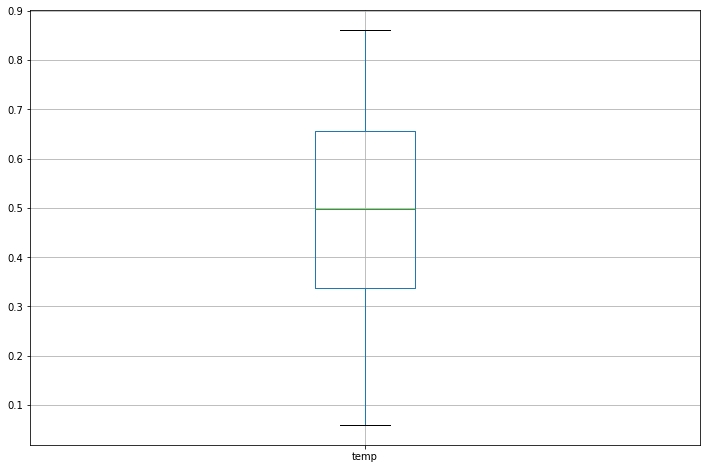

In [24]:
bike_sharing_data[['temp']].boxplot(figsize=(12, 8))

In [25]:
bike_sharing_data['temp_category'] = bike_sharing_data['temp'] > bike_sharing_data['temp'].mean()

In [26]:
bike_sharing_data.sample(10)

,season,mnth,holiday,workingday,weathersit,temp,cnt,temp_category
116,2,4,0,1,2,0.620000,3872,True
464,2,4,0,1,1,0.489167,5585,False
660,4,10,0,1,1,0.487500,7058,False
625,3,9,0,1,2,0.580833,6869,True
417,1,2,0,1,1,0.395833,4773,False
431,1,3,0,1,1,0.404167,4916,False
400,1,2,0,0,2,0.265833,2947,False
94,2,4,0,1,2,0.414167,1795,False
447,2,3,0,1,2,0.601667,8362,True
643,4,10,0,1,1,0.615000,8156,True


In [27]:
bike_sharing_data.groupby('temp_category')['cnt'].describe()

,count,mean,std,min,25%,50%,75%,max
temp_category,,,,,,,,
False,364.0,3387.664835,1691.340133,22.0,1964.5,3301.0,4513.5,8090.0
True,367.0,5611.904632,1475.698228,1115.0,4548.5,5336.0,6897.5,8714.0


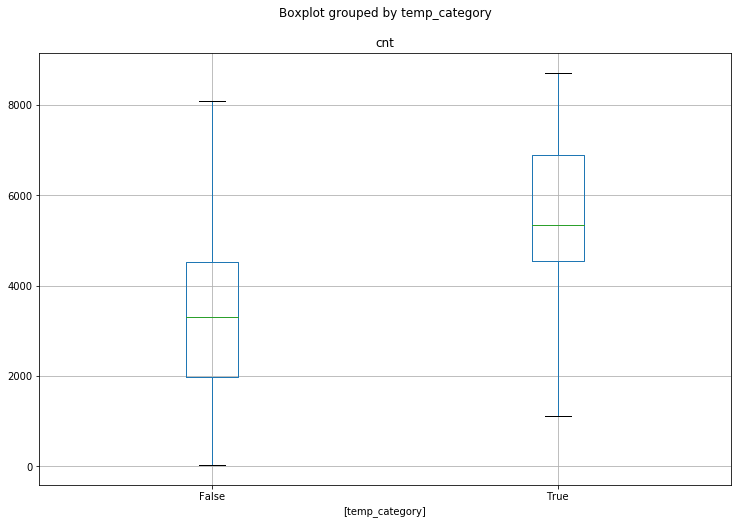

In [28]:
bike_sharing_data.boxplot(column=['cnt'], by=['temp_category'], figsize=(12, 8))

In [29]:
sample_01_temp = bike_sharing_data[(bike_sharing_data['temp_category'] == True)]
sample_02_temp = bike_sharing_data[(bike_sharing_data['temp_category'] == False)]

In [30]:
sample_01_temp.shape, sample_02_temp.shape

((367, 8), (364, 8))

In [31]:
sample_01_temp = sample_01_temp.sample(364)
sample_01_temp.shape, sample_02_temp.shape

((364, 8), (364, 8))

In [32]:
stats.levene(sample_01_temp['cnt'], sample_02_temp['cnt'])

LeveneResult(statistic=4.3968341195123184, pvalue=0.036351115500331238)

(array([  7.,  10.,  25.,  41.,  69.,  61.,  71.,  50.,  23.,   7.]),
 array([-2.81887638, -2.2973036 , -1.77573082, -1.25415804, -0.73258526,
        -0.21101248,  0.3105603 ,  0.83213308,  1.35370587,  1.87527865,
         2.39685143]),
 <a list of 10 Patch objects>)

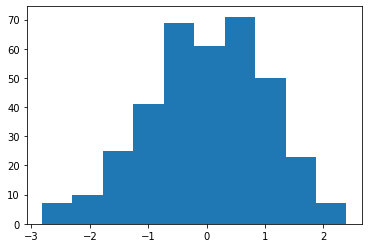

In [33]:
diff = scale(np.array(sample_01_temp['cnt']) - np.array(sample_02_temp['cnt'],  dtype=float))
plt.hist(diff)

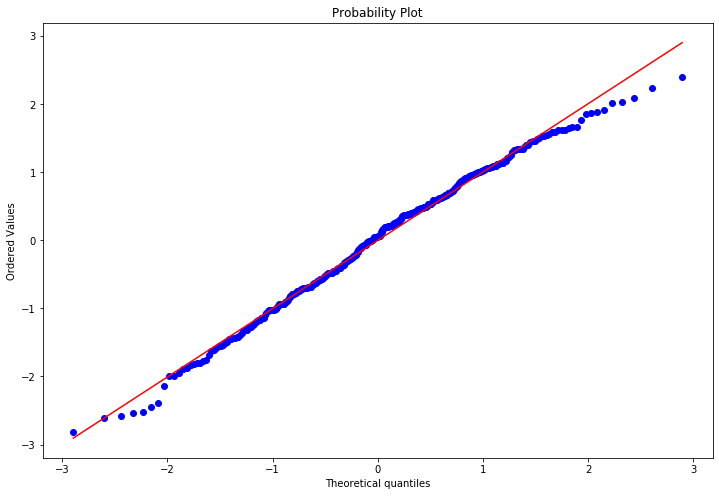

In [34]:
plt.figure(figsize=(12, 8))
stats.probplot(diff, plot=plt)
plt.show()

In [45]:
stats.shapiro(diff)

(0.9923050403594971, 0.05721497908234596)

In [46]:
stats.ttest_ind(sample_01_temp['cnt'], sample_02_temp['cnt'])

Ttest_indResult(statistic=18.87711272037242, pvalue=5.7088047817712123e-65)

In [47]:
descriptives, results = rp.ttest(sample_01_temp['cnt'], sample_02_temp['cnt'], equal_variances=False)

In [48]:
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,cnt,364.0,5611.203297,1479.762144,77.560611,5458.678755,5763.727839
1,cnt,364.0,3387.664835,1691.340133,88.650311,3213.332169,3561.997501
2,combined,728.0,4499.434066,1938.922723,71.861257,4358.353716,4640.514416


In [49]:
print(results)

              Welch's t-test    results
0  Difference (cnt - cnt) =   2223.5385
1      Degrees of freedom =    713.4090
2                       t =     18.8771
3   Two side test p value =      0.0000
4  Difference < 0 p value =      1.0000
5  Difference > 0 p value =      0.0000
6               Cohen's d =      1.3993
7               Hedge's g =      1.3978
8           Glass's delta =      1.5026
9                       r =      0.5772
